In [1]:
#Importing all required libraries
#Created by Sanket Karve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter
!pip install PyPortfolioOpt
#Installing the Portfolio Optimzation Library
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter

     |████████████████████████████████| 48 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 6.8 MB/s eta 0:00:01


In [13]:
tickers = ['GOOGL','FB','AAPL','NFLX','AMZN']
thelen = len(tickers)
price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2019-06-20', end = '2021-01-06', data_source='yahoo')
    price_data.append(prices[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.tail()

,GOOGL,FB,AAPL,NFLX,AMZN
Date,,,,,
2020-12-30,1736.250000,271.869995,133.720001,524.590027,3285.850098
2020-12-31,1752.640015,273.160004,132.690002,540.729980,3256.929932
2021-01-04,1726.130005,268.940002,129.410004,522.859985,3186.629883
2021-01-05,1740.050049,270.970001,131.009995,520.799988,3218.510010
2021-01-06,1722.880005,263.309998,126.599998,500.489990,3138.379883


In [31]:
# Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
print(mu)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)
print(Sigma)
#Max Sharpe Ratio - Tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
#sharpe_pfolio = ef.max_sharpe() 
sharpe_pfolio = ef.min_volatility()
print(sharpe_pfolio)
#May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt = ef.clean_weights()
print(sharpe_pwt)


GOOGL    0.326061
FB       0.236699
AAPL     0.844067
NFLX     0.225823
AMZN     0.374538
dtype: float64
          GOOGL        FB      AAPL      NFLX      AMZN
GOOGL  0.112664  0.100109  0.097419  0.071433  0.071901
FB     0.100109  0.154549  0.116605  0.091987  0.088645
AAPL   0.097419  0.116605  0.159677  0.087512  0.090569
NFLX   0.071433  0.091987  0.087512  0.179276  0.089452
AMZN   0.071901  0.088645  0.090569  0.089452  0.108815
OrderedDict([('GOOGL', 0.4510777700768963), ('FB', 0.0), ('AAPL', 0.0), ('NFLX', 0.099280346440368), ('AMZN', 0.4496418834827357)])
OrderedDict([('GOOGL', 0.45108), ('FB', 0.0), ('AAPL', 0.0), ('NFLX', 0.09928), ('AMZN', 0.44964)])


In [32]:
#VaR Calculation
ticker_rx2 = []
#Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio
sh_wt = list(sharpe_pwt.values())
sh_wt = np.array(sh_wt)

print(sh_wt)

[0.45108 0.      0.      0.09928 0.44964]


In [33]:
# Convert into cumulative
for a in range(thelen):
    ticker_rx = df_stocks[[tickers[a]]].pct_change()
    ticker_rx = (ticker_rx+1).cumprod()
    ticker_rx2.append(ticker_rx[[tickers[a]]])
ticker_final = pd.concat(ticker_rx2,axis=1)
ticker_final

,GOOGL,FB,AAPL,NFLX,AMZN
Date,,,,,
2019-06-20,NaN,NaN,NaN,NaN,NaN
2019-06-21,1.010932,1.008495,0.996591,1.010953,0.996408
2019-06-24,1.003144,1.016198,0.995588,1.015963,0.997764
2019-06-25,0.976985,0.996359,0.980497,0.986556,0.979189
2019-06-26,0.970464,0.990134,1.001705,0.991758,0.989386
...,...,...,...,...,...
2020-12-30,1.559693,1.434443,2.723227,1.436407,1.712995
2020-12-31,1.574416,1.441249,2.702251,1.480600,1.697918
2021-01-04,1.550602,1.418984,2.635454,1.431669,1.661269


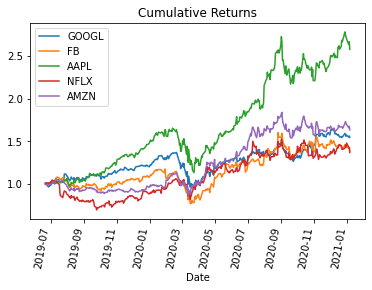

In [34]:
#Plot graph of Cumulative/HPR of all stocks
for i, col in enumerate(ticker_final.columns):
    ticker_final[col].plot()
plt.title('Cumulative Returns')
plt.xticks(rotation=80)
plt.legend(ticker_final.columns)
plt.show()

In [35]:
#Taking Latest Values of Return
pret = []
pre1 = []
price =[]
for x in range(thelen):
    pret.append(ticker_final.iloc[[-1],[x]])
    price.append((df_stocks.iloc[[-1],[x]]))
pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()
ex_rtn = pre1.dot(sh_wt)
print('The weighted expected portfolio return for selected time period is '+ str(ex_rtn))
price = price.dot(sh_wt) #Calculating weighted value
print(ex_rtn, varsigma, price)

The weighted expected portfolio return for selected time period is [1.56984647]
[1.56984647] 0.4480276429344909 Date
2021-01-06    2237.986489
dtype: float64


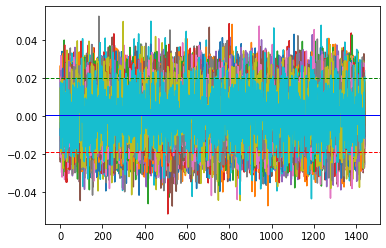

In [42]:
# Run Montecarlo
from scipy.stats import norm
import math

Time=1440 #No of days(steps or trading days in this case)
lt_price=[]
final_res=[]
#for i in range(10000): #10000 runs of simulation
for i in range(50): #10000 runs of simulation
    daily_returns = (np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time))
    plt.plot(daily_returns)
plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)
plt.show()

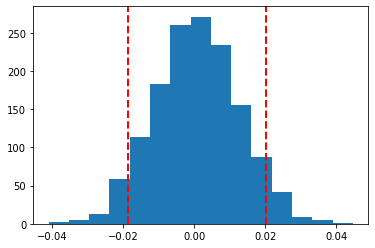

In [43]:
plt.hist(daily_returns,bins=15)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

In [45]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95)) #VaR - Minimum loss of 5.7% at a 5% probability, also a gain can be higher than 15% with a 5 % probability
pvalue = 100000 #portfolio value
print('$Amount required to cover minimum losses for one day is ' + str(pvalue* - np.percentile(daily_returns,5)))

-0.01860227257262061 0.020296723742095894
$Amount required to cover minimum losses for one day is 1860.2272572620611
